In [ ]:
!pip install gymnasium
!pip install imageio
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.4 MB/s eta 0:00:00


In [ ]:
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque
import gymnasium as gym
from gymnasium import spaces

In [ ]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(QNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.layers(x)


class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.FloatTensor(states).to(device),
            torch.LongTensor(actions).to(device),
            torch.FloatTensor(rewards).to(device),
            torch.FloatTensor(next_states).to(device),
            torch.FloatTensor(dones).to(device),
        )

    def __len__(self):
        return len(self.buffer)

In [ ]:
def plot_rewards(reward_history, window=50):
    """Plot Reward vs Episode with optional moving average."""
    plt.figure(figsize=(9, 5))
    plt.plot(reward_history, color='blue', alpha=0.6, label="Reward per Episode")

    if len(reward_history) >= window:
        moving_avg = np.convolve(reward_history, np.ones(window)/window, mode='valid')
        plt.plot(range(window - 1, len(reward_history)), moving_avg, color='red', label=f"{window}-ep Moving Avg")

    plt.title("Reward vs Episodes (MountainCar DQN)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def train_dqn(
    env_name="MountainCar-v0",
    episodes=1000,
    batch_size=64,
    gamma=0.99,
    lr=1e-3,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    target_update_freq=10,
    device= device
):
    env = gym.make(env_name)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    policy_net = QNetwork(state_size, action_size).to(device)
    target_net = QNetwork(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    buffer = ReplayBuffer()

    epsilon = epsilon_start
    all_rewards = []
    goal_reached = False

    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = torch.argmax(q_values).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            position, velocity = next_state
            shaped_reward = reward + (position + 0.5)

            buffer.push(state, action, shaped_reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(buffer) >= batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    target = rewards + gamma * next_q_values * (1 - dones)
                loss = nn.MSELoss()(q_values, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        all_rewards.append(total_reward)

        if episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if episode % 1000 == 0:
            avg_reward = np.mean(all_rewards[-1000:])
            print(f"Episode {episode}/{episodes} | Avg Reward (last 1000): {avg_reward:.2f} | Epsilon: {epsilon:.2f}")

        if np.mean(all_rewards[-10:]) > -110:
            print(f"Early stop at episode {episode}: near-optimal performance.")
            goal_reached = True
            break

    env.close()
    return policy_net, goal_reached, all_rewards


In [ ]:
def test_agent(policy_net, env_name="MountainCar-v0", runs=5, render=False, device=device):
    env = gym.make(env_name, render_mode="human" if render else None)
    print("\n=== Running Evaluation Tests ===")
    success_count = 0
    rewards = []

    for i in range(runs):
        state, _ = env.reset()
        total_reward = 0
        done = False
        steps = 0

        while not done:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = policy_net(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1
            state = next_state

        rewards.append(total_reward)
        reached_goal = state[0] >= 0.5
        if reached_goal:
            success_count += 1
            print(f"Run {i+1}: Goal Reached in {steps} steps (Reward: {total_reward:.2f})")
        else:
            print(f"Run {i+1}: Goal Not Reached (Final Pos: {state[0]:.2f}, Reward: {total_reward:.2f})")

    avg_reward = np.mean(rewards)
    print(f"\n=== Summary ===")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Goal reached in {success_count}/{runs} runs ({(success_count / runs) * 100:.1f}% success rate)")
    env.close()



In [ ]:
trained_policy, goal_flag, reward_history = train_dqn(episodes=5000)

/tmp/ipython-input-3505766926.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  torch.FloatTensor(states).to(device),


Episode 1000/5000 | Avg Reward (last 1000): -191.42 | Epsilon: 0.05
Early stop at episode 1268: near-optimal performance.


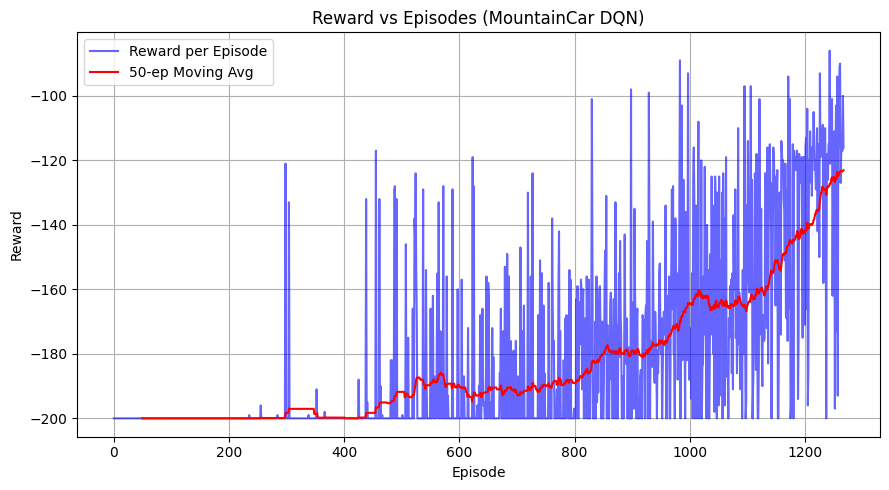

In [ ]:
plot_rewards(reward_history, window=50)


In [ ]:
test_agent(trained_policy, runs=5)


=== Running Evaluation Tests ===
Run 1: Goal Reached in 118 steps (Reward: -118.00)
Run 2: Goal Reached in 121 steps (Reward: -121.00)
Run 3: Goal Reached in 88 steps (Reward: -88.00)
Run 4: Goal Reached in 118 steps (Reward: -118.00)
Run 5: Goal Reached in 117 steps (Reward: -117.00)

=== Summary ===
Average Reward: -112.40
Goal reached in 5/5 runs (100.0% success rate)


In [ ]:
## -- Graph Question on shortest path
class GraphEnv:
    def __init__(self, n_nodes, edges, start, goal, max_steps=50):
        self.n = n_nodes
        self.adj = {i: [] for i in range(n_nodes)}
        for u, v, w in edges:
            self.adj[u].append((v, w))
        self.start = start
        self.goal = goal
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.state = self.start
        self.steps = 0
        return self.state

    def step(self, action):
        neighbors = self.adj[self.state]
        next_node, w = neighbors[action]
        self.steps += 1
        done = False
        if next_node == self.goal:
            reward = 100.0 - w
            done = True
        else:
            reward = -w
            if self.steps >= self.max_steps:
                done = True
        self.state = next_node
        return self.state, reward, done, {}

    def valid_actions(self, state=None):
        if state is None:
            state = self.state
        return list(range(len(self.adj[state])))


In [ ]:
def train_q_learning(env, episodes=2000, alpha=0.5, gamma=0.99, eps_start=1.0, eps_end=0.05):
    Q = {s: np.zeros(len(env.adj[s])) for s in range(env.n)}
    eps_decay = (eps_start - eps_end) / episodes
    eps = eps_start
    start_time = time.time()
    for ep in range(episodes):
        s = env.reset()
        done = False
        while not done:
            valid = env.valid_actions(s)
            if random.random() < eps:
                a = random.choice(valid)
            else:
                a = int(np.argmax(Q[s]))
            next_s, r, done, _ = env.step(a)
            if not done and len(env.adj[next_s]) > 0:
                Q_next_max = np.max(Q[next_s])
            else:
                Q_next_max = 0.0
            Q[s][a] += alpha * (r + gamma * Q_next_max - Q[s][a])
            s = next_s
        eps = max(eps - eps_decay, eps_end)
    train_time = time.time() - start_time
    return Q, train_time


def evaluate_q(env, Q):
    s = env.reset()
    path = [s]
    done = False
    while not done and len(path) < env.max_steps:
        a = int(np.argmax(Q[s]))
        s, r, done, _ = env.step(a)
        path.append(s)
        if done:
            break
    return path


In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.net(x)


class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, min(len(self.buffer), batch_size))
        s, a, r, s2, d = zip(*batch)
        return np.array(s), a, r, np.array(s2), d

    def __len__(self):
        return len(self.buffer)

In [ ]:
def train_dqn(env, episodes=2000, gamma=0.99, eps_start=1.0, eps_end=0.05, lr=1e-3, batch_size=64, target_update=50, early_stop_patience=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    state_dim = env.n
    action_dim = max(len(env.adj[s]) for s in range(env.n))

    policy_net = DQN(state_dim, action_dim).to(device)
    target_net = DQN(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    buffer = ReplayBuffer(10000)

    eps = eps_start
    eps_decay = (eps_start - eps_end) / episodes
    start_time = time.time()

    best_reward = -float('inf')
    no_improve_count = 0

    for ep in range(episodes):
        s = env.reset()
        s_vec = np.zeros(env.n)
        s_vec[s] = 1.0
        done = False
        total_reward = 0

        while not done:
            valid = env.valid_actions(s)
            if random.random() < eps:
                a = random.choice(valid)
            else:
                with torch.no_grad():
                    q_values = policy_net(torch.FloatTensor(s_vec).to(device))
                    mask = torch.full((action_dim,), -1e9, device=device)
                    mask[valid] = q_values[valid]
                    a = int(torch.argmax(mask).item())

            next_s, r, done, _ = env.step(a)
            total_reward += r
            ns_vec = np.zeros(env.n)
            ns_vec[next_s] = 1.0

            buffer.push(s_vec, a, r, ns_vec, done)
            s, s_vec = next_s, ns_vec

            if len(buffer) >= batch_size:
                s_b, a_b, r_b, s2_b, d_b = buffer.sample(batch_size)
                s_b = torch.FloatTensor(s_b).to(device)
                s2_b = torch.FloatTensor(s2_b).to(device)
                a_b = torch.LongTensor(a_b).to(device)
                r_b = torch.FloatTensor(r_b).to(device)
                d_b = torch.FloatTensor(d_b).to(device)

                q_values = policy_net(s_b).gather(1, a_b.unsqueeze(1)).squeeze()
                with torch.no_grad():
                    q_next = target_net(s2_b).max(1)[0]
                    target = r_b + gamma * q_next * (1 - d_b)

                loss = nn.MSELoss()(q_values, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        eps = max(eps - eps_decay, eps_end)

        if total_reward > best_reward:
            best_reward = total_reward
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= early_stop_patience:
            print(f"Early stopping at episode {ep} with best reward {best_reward:.2f}")
            break

        if (ep + 1) % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

    train_time = time.time() - start_time
    return policy_net, train_time

In [ ]:
def evaluate_dqn(env, net):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    s = env.reset()
    path = [s]
    done = False
    action_dim = max(len(env.adj[s]) for s in range(env.n))
    while not done and len(path) < env.max_steps:
        s_vec = np.zeros(env.n)
        s_vec[s] = 1.0
        with torch.no_grad():
            q_values = net(torch.FloatTensor(s_vec).to(device))
            mask = torch.full((action_dim,), -1e9, device=device)
            mask[env.valid_actions(s)] = q_values[env.valid_actions(s)]
            a = int(torch.argmax(mask).item())
        s, _, done, _ = env.step(a)
        path.append(s)
    return path

In [ ]:
def floyd_warshall_table(edges, n_nodes):
    INF = float('inf')
    dist = np.full((n_nodes, n_nodes), INF)
    np.fill_diagonal(dist, 0)
    for u, v, w in edges:
        dist[u][v] = w
        dist[v][u] = w
    for k in range(n_nodes):
        for i in range(n_nodes):
            for j in range(n_nodes):
                if dist[i][j] > dist[i][k] + dist[k][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]
    df = pd.DataFrame(dist, columns=[f'Node {i}' for i in range(n_nodes)])
    df.index = [f'Node {i}' for i in range(n_nodes)]
    return df

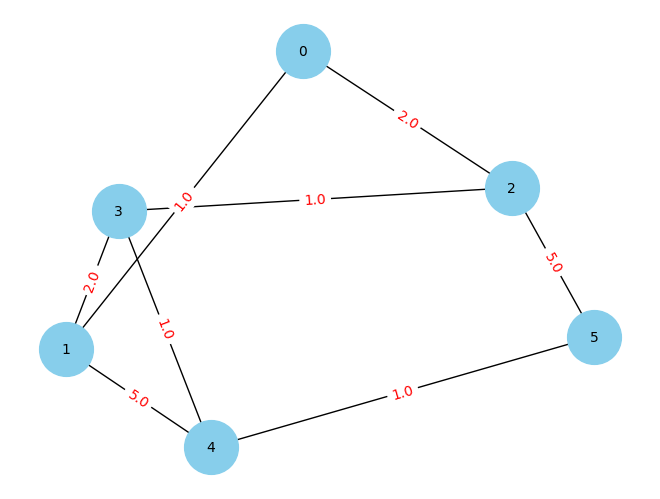

In [ ]:
edges = [
    (0, 1, 1.0), (0, 2, 2.0),
    (1, 3, 2.0), (2, 3, 1.0),
    (1, 4, 5.0), (3, 4, 1.0),
    (4, 5, 1.0), (2, 5, 5.0)
]

G = nx.Graph()
G.add_weighted_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.show()


In [ ]:

print("\n--- Floyd Warshall Shortest Distance Table ---")
table = floyd_warshall_table(edges, 6)
print(table)



--- Floyd Warshall Shortest Distance Table ---
        Node 0  Node 1  Node 2  Node 3  Node 4  Node 5
Node 0     0.0     1.0     2.0     3.0     4.0     5.0
Node 1     1.0     0.0     3.0     2.0     3.0     4.0
Node 2     2.0     3.0     0.0     1.0     2.0     3.0
Node 3     3.0     2.0     1.0     0.0     1.0     2.0
Node 4     4.0     3.0     2.0     1.0     0.0     1.0
Node 5     5.0     4.0     3.0     2.0     1.0     0.0


In [ ]:
fw_distance = table.loc['Node 0', 'Node 5']
print(f"\nInitial shortest distance (Floyd-Warshall): {fw_distance}")


Initial shortest distance (Floyd-Warshall): 5.0


In [ ]:
env = GraphEnv(6, edges, 0, 5)


Q, q_time = train_q_learning(env)
q_path = evaluate_q(env, Q)


In [ ]:
dqn, dqn_time = train_dqn(env, early_stop_patience=2000)
dqn_path = evaluate_dqn(env, dqn)

In [ ]:
print(f"\nQ-learning path: {q_path}, Distance: {len(q_path)}")
print(f"DQN path: {dqn_path}, Distance: {len(dqn_path)}")



Q-learning path: [0, 1, 3, 4, 5], Distance: 5
DQN path: [0, 1, 3, 4, 5], Distance: 5


In [ ]:
print("\n--- Comparison Table ---")
comparison = pd.DataFrame([
    {"Method": "Floyd-Warshall", "Shortest Distance": fw_distance, "Path": "Optimal Analytical"},
    {"Method": "Q-learning", "Shortest Distance": len(q_path), "Path": q_path},
    {"Method": "DQN (PyTorch)", "Shortest Distance": len(dqn_path), "Path": dqn_path}
])
print(comparison)


--- Comparison Table ---
           Method  Shortest Distance                Path
0  Floyd-Warshall                5.0  Optimal Analytical
1      Q-learning                5.0     [0, 1, 3, 4, 5]
2   DQN (PyTorch)                5.0     [0, 1, 3, 4, 5]


In [ ]:
## --DQN method to solve Roulette problem.

class RouletteEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, spins_per_episode=10):
        super().__init__()
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Discrete(1)
        self.state = np.array([0.0])
        self.spins_per_episode = spins_per_episode
        self.current_spin = 0

    def spin(self):
        number = np.random.randint(0, 37)
        if number == 0:
            return 2  # green
        elif 1 <= number <= 18:
            return 0  # red
        else:
            return 1  # black

    def step(self, action):
        outcome = self.spin()
        if action == outcome:
            reward = 35.0 if action == 2 else 1.0
        else:
            reward = -1.0

        # Reward normalization
        reward = reward / 10.0  # scale down large wins
        self.current_spin += 1
        done = self.current_spin >= self.spins_per_episode

        return self.state, reward, done, False, {}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([0.0])
        self.current_spin = 0
        return self.state, {}

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.model(x)


class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.FloatTensor(dones)
        )

    def __len__(self):
        return len(self.buffer)

In [ ]:
def train_dqn(env, episodes=5000, batch_size=64, gamma=0.95, lr=5e-3):
    state_size = 1
    action_size = env.action_space.n

    policy_net = QNetwork(state_size, action_size)
    target_net = QNetwork(state_size, action_size)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    buffer = ReplayBuffer()

    epsilon = 1.0
    epsilon_decay = 0.997
    epsilon_min = 0.05
    update_target_every = 100

    all_rewards = []

    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = policy_net(torch.FloatTensor(state))
                    action = torch.argmax(q_values).item()

            next_state, reward, done, _, _ = env.step(action)
            buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(buffer) >= batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    target = rewards + gamma * next_q_values * (1 - dones)
                loss = nn.MSELoss()(q_values, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        all_rewards.append(total_reward)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)


        if episode % update_target_every == 0:
            target_net.load_state_dict(policy_net.state_dict())


        if episode % 1000== 0:
            avg_reward = np.mean(all_rewards[-1000:])
            print(f"Episode {episode}/{episodes} | Avg Reward (last 1000): {avg_reward:.2f} | Epsilon: {epsilon:.2f}")

    return policy_net


In [ ]:
def test_agent(policy_net, env, runs=10):
    print("\n=== Running Evaluation Tests ===")
    total_rewards = []
    success_count = 0

    for i in range(runs):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            with torch.no_grad():
                q_values = policy_net(torch.FloatTensor(state))
                action = torch.argmax(q_values).item()
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward

        total_rewards.append(total_reward)
        if total_reward >= 0:
            success_count += 1
            print(f"Run {i+1}: Total Reward = {total_reward:.2f} Goal Reached")
        else:
            print(f"Run {i+1}: Total Reward = {total_reward:.2f} Goal Not Reached")

    avg_reward = np.mean(total_rewards)
    print("\n=== Summary ===")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Goal reached in {success_count}/{runs} runs ({(success_count/runs)*100:.1f}% success rate)")



In [ ]:
env = RouletteEnv(spins_per_episode=10)
trained_policy = train_dqn(env, episodes=5000)

Episode 1000/5000 | Avg Reward (last 1000): -0.01 | Epsilon: 0.05
Episode 2000/5000 | Avg Reward (last 1000): -0.06 | Epsilon: 0.05
Episode 3000/5000 | Avg Reward (last 1000): -0.04 | Epsilon: 0.05
Episode 4000/5000 | Avg Reward (last 1000): -0.07 | Epsilon: 0.05
Episode 5000/5000 | Avg Reward (last 1000): -0.01 | Epsilon: 0.05


In [ ]:
test_agent(trained_policy, env, runs=10)


=== Running Evaluation Tests ===
Run 1: Total Reward = -1.00 Goal Not Reached
Run 2: Total Reward = -1.00 Goal Not Reached
Run 3: Total Reward = -1.00 Goal Not Reached
Run 4: Total Reward = -1.00 Goal Not Reached
Run 5: Total Reward = 2.60 Goal Reached
Run 6: Total Reward = -1.00 Goal Not Reached
Run 7: Total Reward = -1.00 Goal Not Reached
Run 8: Total Reward = -1.00 Goal Not Reached
Run 9: Total Reward = -1.00 Goal Not Reached
Run 10: Total Reward = 2.60 Goal Reached

=== Summary ===
Average Reward: -0.28
Goal reached in 2/10 runs (20.0% success rate)
